In [75]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.transform import from_origin
from rasterio.features import geometry_mask


In [2]:
DATA_FOLDER = "../data/"
file_name = "CHELSA_tmean_1979_01_V1.2.1.tif"

img = cv2.imread(os.path.join(DATA_FOLDER, file_name))

print(img.shape)

print(img[0, 0])

(20880, 43200, 3)
[9 9 9]


# Chelsa Data
The image is of size (20880, 43200, 3). Axis 2 is a repetition of the value, hence we get all the information we need with a (20880, 43200) array.

From the size of the image, the coordinates system used is:

- Projection: Geographic (latitude/longitude)
- Datum: WGS84 (World Geodetic System 1984)

The resolution is 30 arc seconds. When downsampling with a kernel size of 10, the resolution is ~5 arc minutes. This represents ~9.26 kilometers at the equator (should be enough for our data analysis).

# Geopanda's *naturalearth_lowres* 

- has a 'geometry' column containg data of type <class 'shapely.geometry.multipolygon.MultiPolygon'>
- Datum: WGS84 but given in unit of degrees

In [3]:

print(img.min(), img.max(), img.mean())
print(np.sum(img[:,:,0] != img[:,:,1]))

temp = img[:,:,0]

8 12 10.294594216732298
0


(20880, 43200)


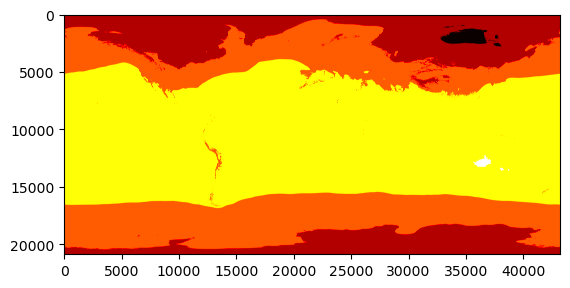

In [ ]:
''' Vizualiie temperature at 1 point in time '''    
print(temp.shape)

fig, ax = plt.subplots()
im = ax.imshow(temp, cmap='hot')  # Initialize with the first frame
plt.show()

In [67]:
''' Load .tif file, downsample and return as numpy array '''

def load_geotiff(file_name):
    _ = np.newaxis
    # downsampling_layer = torch.nn.MaxPool2d(kernel_size=10, stride=10)
    downsampling_layer = torch.nn.AvgPool2d(kernel_size=10, stride=10)
    # downsampling_layer = torch.nn.Conv2d(1, 1, kernel_size=10, stride=10)

    with rasterio.open(file_name) as src:
        array = src.read(1, out_dtype=np.float32)
        data = downsampling_layer(torch.tensor(array[_,_,:,:], dtype=torch.float32)).detach().numpy()

    return data
    


(1, 1, 2088, 4320)


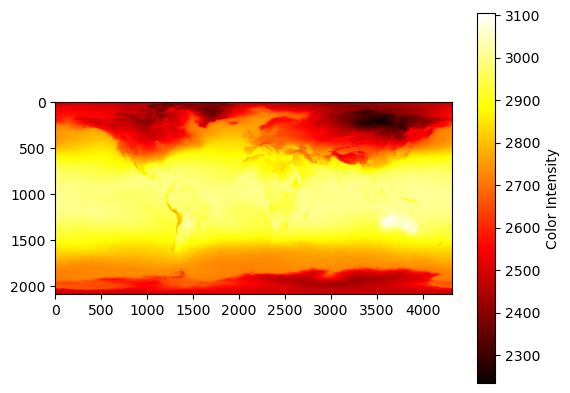

In [68]:
file_name = "CHELSA_tmean_1979_01_V1.2.1.tif"
data = load_geotiff(os.path.join(DATA_FOLDER, file_name))
print(data.shape)

# Visualize the results
fig, ax = plt.subplots()
im = ax.imshow(data[0,0], cmap='hot')  # Initialize with the first frame
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Color Intensity')  # Optionally, add a label to the colorbar

plt.show()

In [76]:
def calculate_average_temperature_per_country(temperature_data, world_gdf):
    """
    Calculate the average temperature per country.

    Parameters:
    - temperature_data: numpy array of shape (2088, 4320) with temperature data.
    - world_gdf: GeoDataFrame of countries in the WGS84 coordinate system.

    Returns:
    - GeoDataFrame with an additional column 'mean_temperature' for each country's average temperature.
    """
    # Define pixel size and transformation for WGS84
    pixel_size = 360 / temperature_data.shape[1]  # Calculate pixel size dynamically based on array dimensions
    transform = from_origin(-180, 90, pixel_size, pixel_size)

    mean_temperatures = []

    # Loop through each country and compute the mean temperature
    for _, country in world_gdf.iterrows():
        # Convert country geometry to GeoJSON format
        geom = [country['geometry'].__geo_interface__]

        # Create a mask for the current country geometry
        mask = geometry_mask(
            geometries=geom,
            out_shape=temperature_data.shape,
            transform=transform,
            invert=True  # True where the geometry is located
        )

        # Apply mask to the temperature data
        masked_data = np.where(mask, temperature_data, np.nan)

        # Calculate the mean temperature for the country, ignoring NaNs
        mean_temp = np.nanmean(masked_data)
        mean_temperatures.append(mean_temp)

    return mean_temperatures


/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_99972/1141162576.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


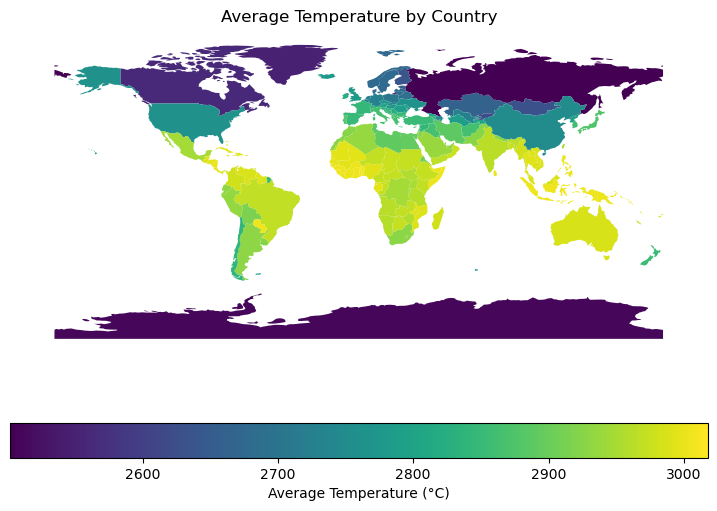

In [77]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
stats = calculate_average_temperature_per_country(data[0,0], world)

world['avg_temp'] = stats

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
world.plot(column='avg_temp', ax=ax, legend=True,
           legend_kwds={'label': 'Average Temperature (°C)',
                        'orientation': 'horizontal'},
           missing_kwds={'color': 'lightgrey'})
plt.title('Average Temperature by Country')
plt.axis('off')
plt.show()

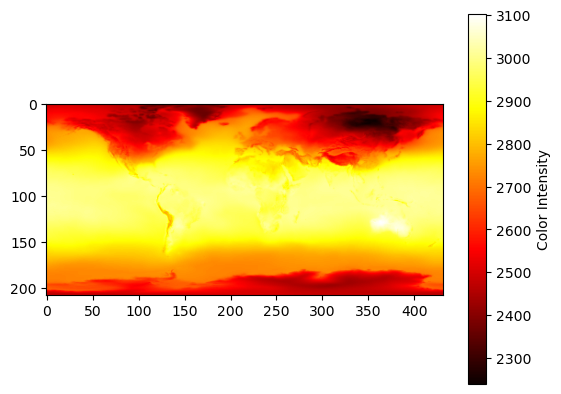

In [ ]:
''' Extract temperature data for each country '''

# Reconcile the coordinate systems
transform = from_origin(-180, 90, 360/4320, 180/2088)
temp = data[0,0]
# Create a temporary GeoTIFF file
with rasterio.open('temp.tif', 'w', driver='GTiff', height=temp.shape[0], width=temp.shape[1],
                   count=1, dtype=temp.dtype, crs='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                   transform=transform) as dst:
    dst.write(temp, 1)


# Visualize the results

temp_data = load_geotiff('temp.tif')
fig, ax = plt.subplots()
im = ax.imshow(temp_data[0,0], cmap='hot')  # Initialize with the first frame
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Color Intensity')  # Optionally, add a label to the colorbar

plt.show()

# Compute zonal statistics
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
stats = zonal_stats(world, 'temp.tif') #"../data/CHELSA_tmean_1979_01_V1.2.1.tif")

# Add the results to the GeoDataFrame
world['avg_temp'] = stats

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
world.plot(column='avg_temp', ax=ax, legend=True,
           legend_kwds={'label': 'Average Temperature (°C)',
                        'orientation': 'horizontal'},
           missing_kwds={'color': 'lightgrey'})
plt.title('Average Temperature by Country')
plt.axis('off')
plt.show()

In [5]:
print(ds_img.min(), ds_img.max(), ds_img.mean())

8.0 12.0 10.2999735


In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(world.head())

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_99972/634929920.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


       pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  


In [7]:
print(type(world['geometry'][0]))


minx = np.zeros(len(world))
miny = np.zeros(len(world))
maxx = np.zeros(len(world))
maxy = np.zeros(len(world))

for i in range(len(world)):
    minx[i], miny[i], maxx[i], maxy[i] = world['geometry'][i].bounds

print(minx.min(), miny.min(), maxx.max(), maxy.max())

<class 'shapely.geometry.multipolygon.MultiPolygon'>
-180.0 -90.0 180.00000000000006 83.64513000000001
